# CSCN 8245 - Foundations of Machine Learning
# Final Project - Sentiment Analysis of Stock News Articles

### By: Samiksha Rajpal (8908982) and Troy Mazerolle (8972394)

## Introduction

In this project, we want to develop a model that can apply sentiment analysis to stock market news.  To do this, we will use our scrapped news articles (see Appendix B for scrapping source and methodology) with ground truths generated from nltk.sentiment.SentimentIntensityAnalyzer() (see Appendix C for the code to generate ground truths).

In this analysis we will test three feature representation methods: bag-of-words, TF-IDF, and word2vec.  All three methods will be trained on a gradient boosting classifier to evaluate the accuracy of the model that each feature representation method creates.

In [23]:
# Utility and Visualization Libraries
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt

# nltk Libraries
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

# Sci Kit Learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Feature Representation Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# Set seed for Reproducibility
rand = 42

# Setting parameters to run code in appendicies. HIGHLY not recommended since doing so can mess up saved files, but option is available.
run_appendix_A = False
run_appendix_B = False
run_appendix_C = False
run_appendix_D = False

Before continuing, we are going to write a function that will perform basic string cleaning and formatting.  This function is a slightly modified version of the function written by Troy for lab 8.

In [24]:
def string_formatter(input_string):

    punctuation_list = list(string.punctuation)
    
    # Tokenize
    token_list = word_tokenize(input_string) 
    # Remove Stop Words
    # stop_words_removed = [word for word in token_list if word not in stopwords.words('english')] 
    # Remove Punctuation
    stop_words_punctuation_removed = [word for word in token_list if word not in punctuation_list] 
    # Put to Lower Case
    stop_words_punctuation_removed_case_folded = [word.lower() for word in stop_words_punctuation_removed] 
    # POS Tagged
    pos_tagged_words = nltk.pos_tag(stop_words_punctuation_removed_case_folded)

    # POS tags for wnl.lematize
    new_tags = [""] * len(pos_tagged_words)
    for i in range(len(pos_tagged_words)):
        if ((pos_tagged_words[i][1] == "VB") | (pos_tagged_words[i][1] == "VBG") |
            (pos_tagged_words[i][1] == "VBD") | (pos_tagged_words[i][1] == "VBN") |
            (pos_tagged_words[i][1] == "VBP") | (pos_tagged_words[i][1] == "VBZ")):
            new_tags[i] = wordnet.VERB
        elif ((pos_tagged_words[i][1] == "JJ") | (pos_tagged_words[i][1] == "JJR") |
              (pos_tagged_words[i][1] == "JJS")):
            new_tags[i] = wordnet.ADJ
        elif ((pos_tagged_words[i][1] == "RB") | (pos_tagged_words[i][1] == "RBR") |
              (pos_tagged_words[i][1] == "RBS") | (pos_tagged_words[i][1] == "WRB")):
            new_tags[i] = wordnet.ADV
        else:
            new_tags[i] = wordnet.NOUN

    # Lemmatization
    wnl = WordNetLemmatizer()
    lemma_words = [""] * len(stop_words_punctuation_removed_case_folded)
    for i in range(len(stop_words_punctuation_removed_case_folded)):
        lemma_words[i] = wnl.lemmatize(stop_words_punctuation_removed_case_folded[i], pos = new_tags[i])

    return " ".join(lemma_words)

Now we load in our data, and output the feature counts and some of the first few rows.  See Appendex C for more details on what constitutes as "POSITIVE", "NEGATIVE", and "NEUTRAL".

In [25]:
sentimentsOfArticles = pd.read_json("DataCollectionAndFormatting/sentimentsOfArticles.json")
counts = Counter(sentimentsOfArticles["Sentiments"])
print(counts)
display(sentimentsOfArticles.head())

Counter({'NEUTRAL': 655, 'NEGATIVE': 565, 'POSITIVE': 498})


,Link,Date,Text,Sentiments
0,https://www.investing.com/news/stock-market-ne...,2023-12-04,"Company OverviewEnphase Energy, Inc. (NASDAQ:E...",POSITIVE
1,https://www.investing.com/news/stock-market-ne...,2023-12-04,SolarEdge Technologies (NASDAQ:SEDG) Inc. has ...,POSITIVE
2,https://www.investing.com/news/stock-market-ne...,2023-12-04,"In the dynamic world of technology, Apple Inc ...",POSITIVE
3,https://www.investing.com/news/stock-market-ne...,2023-12-10,By Anirban Sen (Reuters) - U.S. health insurer...,POSITIVE
4,https://www.investing.com/news/stock-market-ne...,2023-12-04,In the dynamic landscape of software and digit...,POSITIVE


Next we format the text using the string_formatter() function we defined above.  You can see the before-and-after of each string by comparing the texts in the above table to the truncated texts in the output below.

In [26]:
formatted_text = [string_formatter(article) for article in sentimentsOfArticles["Text"]]
for i in range(4):
    print(formatted_text[i][:50]) # only output first 50 characters of article

company overviewenphase energy inc. nasdaq enph a 
solaredge technology nasdaq sedg inc. have be navi
in the dynamic world of technology apple inc nasda
by anirban sen reuters u.s. health insurer cigna n


Lastly, we split the data into training and testing sets before moving on to model building.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(formatted_text, sentimentsOfArticles["Sentiments"], 
                                                    test_size = 0.2, random_state = rand)

## Model 1: Bag-of-Words

The bag-of-words (BoW) model is a text representation technique in natural language processing (NLP) that converts text data into numerical vectors for machine learning applications. It involves tokenizing a text into words, creating a vocabulary, and constructing a document-term matrix where each row represents a document, and each column corresponds to a unique word in the vocabulary, with entries indicating word frequencies. 

First we will create the bag-of-words feature representation,

In [28]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

then we will train gradient boosting model on the features,

In [29]:
clf_bow = GradientBoostingClassifier(random_state = rand)
clf_bow.fit(X_train_bow, y_train)
y_pred_gb_bow = clf_bow.predict(X_test_bow)
print("GB Accuracy:", accuracy_score(y_test, y_pred_gb_bow))

nb_classifier_bow = MultinomialNB()
nb_classifier_bow.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_classifier_bow.predict(X_test_bow)
print("NB Accuracy:", accuracy_score(y_test, y_pred_nb_bow))

svm_classifier_bow = SVC(C=1000) 
svm_classifier_bow.fit(X_train_bow, y_train)
y_pred_svm_bow = svm_classifier_bow.predict(X_test_bow)
print("SVC Accuracy:", accuracy_score(y_test, y_pred_svm_bow))

rf_classifier_bow = RandomForestClassifier() 
rf_classifier_bow.fit(X_train_bow, y_train)
y_pred_rf_bow = rf_classifier_bow.predict(X_test_bow)
print("SVC Accuracy:", accuracy_score(y_test, y_pred_rf_bow))

GB Accuracy: 0.7122093023255814
NB Accuracy: 0.6366279069767442
SVC Accuracy: 0.7645348837209303
SVC Accuracy: 0.6947674418604651


and then we will output the results.

Accuracy: 0.7645348837209303


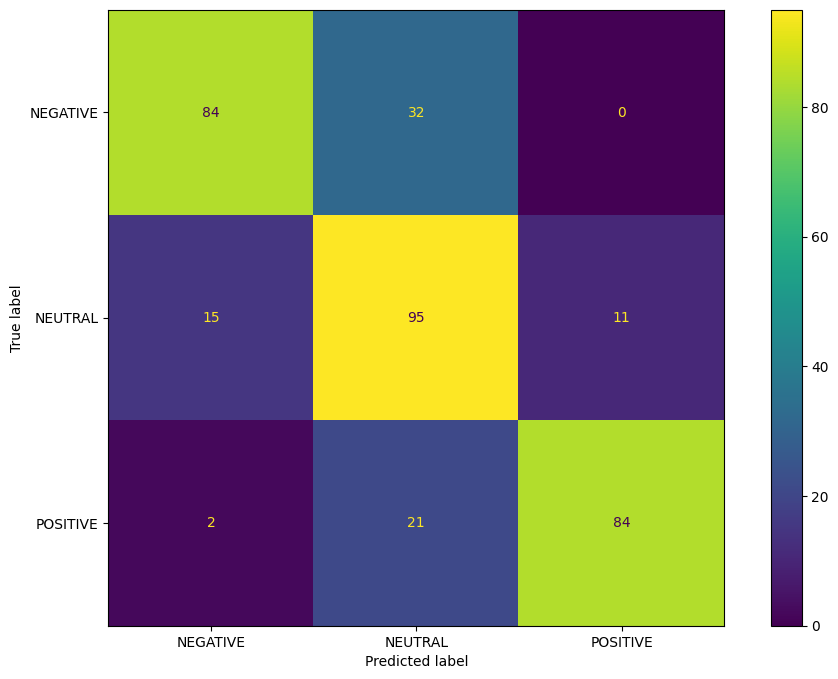

In [30]:
class_names = ["NEGATIVE", "NEUTRAL", "POSITIVE"] # hard-coding for now since list(set(y_test)) puts names in wrong order for use in ConfusionMatrixDisplay()
accuracy_bow = accuracy_score(y_test, y_pred_svm_bow)
print(f"Accuracy: {accuracy_bow}")

fig, ax = plt.subplots(figsize=(12,8))
conf_mat_bow = confusion_matrix(y_test, y_pred_svm_bow)
ConfusionMatrixDisplay(conf_mat_bow, display_labels = class_names).plot(ax = ax);

## Model 2: TF-IDF Matrix

Term Frequency-Inverse Document Frequency (TF-IDF) is a numerical measure used in natural language processing to evaluate the significance of a term within a document in relation to a collection of documents. TF measures the frequency of a term in a specific document, while IDF gauges the rarity of the term across the entire document collection. The TF-IDF score for a term is calculated by multiplying these values, emphasizing terms that are both frequent within a document and uncommon across the entire corpus. 

First we will create the TF-IDF feature representation,

In [31]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

then we will train gradient boosting model on the features,

In [32]:
# clf_tfidf = GradientBoostingClassifier(random_state = rand)
clf_tfidf = SVC(C=1000) 
clf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

and then we will output the results.

Accuracy: 0.7122093023255814


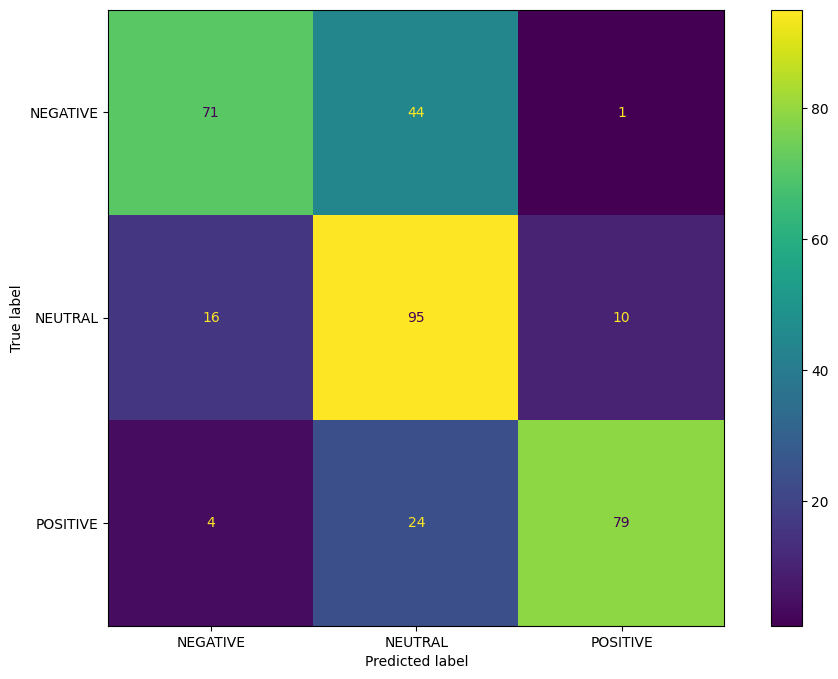

In [33]:
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print(f"Accuracy: {accuracy_tfidf}")

fig, ax = plt.subplots(figsize=(12,8))
conf_mat_tfidf = confusion_matrix(y_test, y_pred_tfidf)
ConfusionMatrixDisplay(conf_mat_tfidf, display_labels = class_names).plot(ax = ax);

## Model 3: Word2Vec 

Word2Vec is a popular technique in natural language processing (NLP) that is used to represent words as continuous vector embeddings in a high-dimensional space. Word2Vec captures semantic relationships between words by learning distributed representations based on the context in which words appear. 

First we will create the word2vec feature representation,

In [34]:
size = 50
tokenized_sentences_train = [word_tokenize(sentence) for sentence in X_train]
w2v_model = Word2Vec(sentences = tokenized_sentences_train, vector_size = size, window = 5, min_count = 1, workers = 4)
X_train_word2vec = []
for tokened_sentence in tokenized_sentences_train:
    num_words = len(tokened_sentence)
    sentence_vector = np.zeros(size)
    for word in tokened_sentence:
        try:
            word_vector = w2v_model.wv[word]
            sentence_vector += word_vector
        except:
            continue
    sentence_vector /= num_words
    X_train_word2vec.append(sentence_vector)

tokenized_sentences_test = [word_tokenize(sentence) for sentence in X_test]
X_test_word2vec = []
for tokened_sentence in tokenized_sentences_test:
    num_words = len(tokened_sentence)
    sentence_vector = np.zeros(size)
    for word in tokened_sentence:
        try:
            word_vector = w2v_model.wv[word]
            sentence_vector += word_vector
        except:
            continue
    sentence_vector /= num_words
    X_test_word2vec.append(sentence_vector)

then we will train gradient boosting model on the features,

In [35]:
# clf_w2v = GradientBoostingClassifier(random_state = rand)
clf_w2v = SVC(C=1000) 
clf_w2v.fit(X_train_word2vec, y_train)
y_pred_w2v = clf_w2v.predict(X_test_word2vec)

and then we will output the results.

Accuracy: 0.6337209302325582


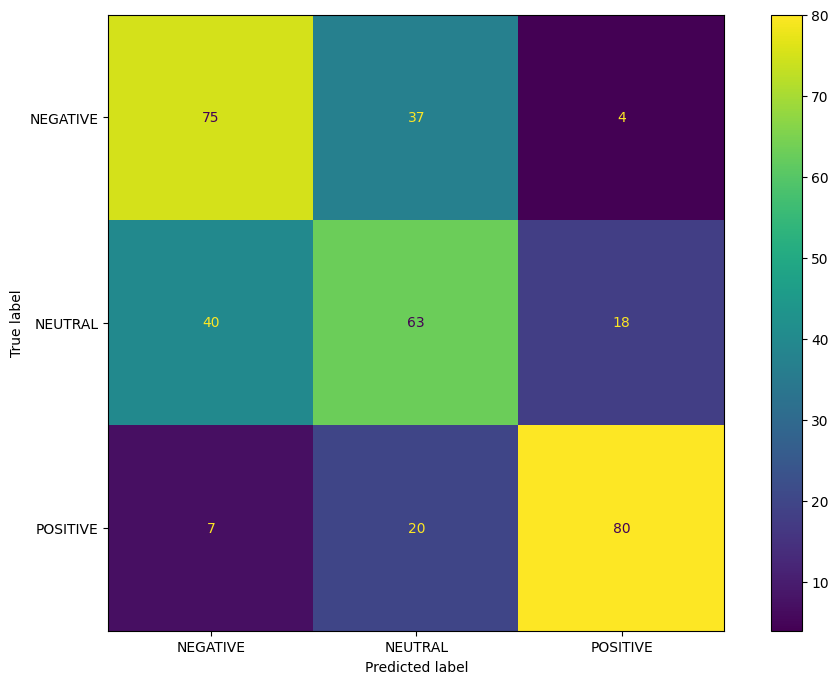

In [36]:
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
print(f"Accuracy: {accuracy_w2v}")

fig, ax = plt.subplots(figsize=(12,8))
conf_mat_w2v = confusion_matrix(y_test, y_pred_w2v)
ConfusionMatrixDisplay(conf_mat_w2v, display_labels = class_names).plot(ax = ax);

## Analysis

The bag-of-words feature extraction method produces the highest accuracy at about 76%.  Furthermore, it also has the most amount of correctly-classified "POSITIVE" and "NEGATIVE" sentiments at 168 correct classifications (note that I did not include articles correctly classified as "NEUTRAL").  For this analysis, we will mainly foculs on the model trained on the bag-of-words feature extraction method since it will be the model we use in the main script and the other two models share similar characteristics to it.

We will output the results of the bag-of-words method again:

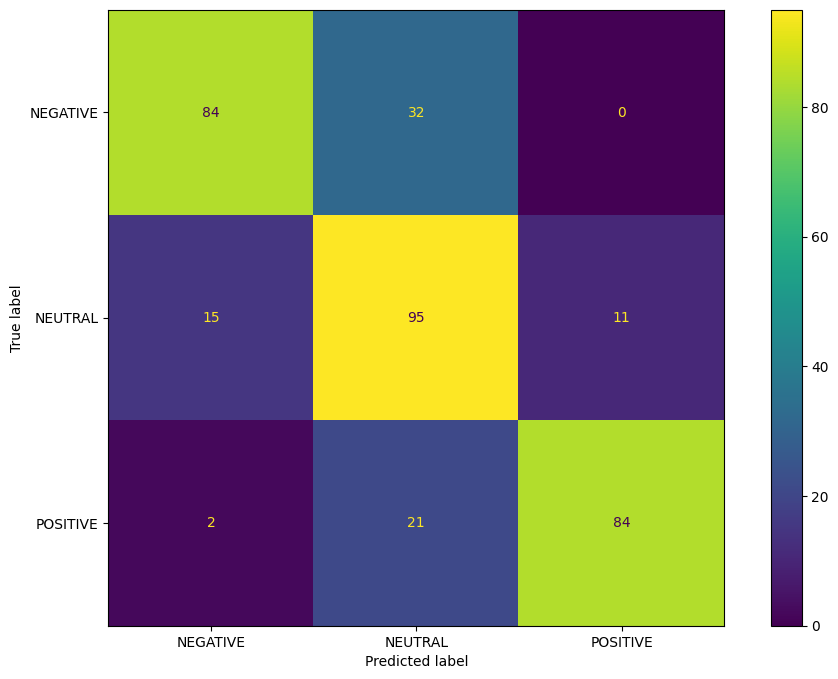

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
conf_mat_tfidf = confusion_matrix(y_test, y_pred_svm_bow)
ConfusionMatrixDisplay(conf_mat_tfidf, display_labels = class_names).plot(ax = ax);

When we say that this model is 76% accurate, we are basically saying that 76% of the articles in the testing set were classified EXACTLY correct.  While this is a fair evaluation training metric, it is important to understand what it means when the model predicts the sentiment to be "POSITIVE" or "NEGATIVE" with the context of the above results.

In the model above, out of the $2 + 21 + 84 = 107$ actual "POSITIVE" results there were to be classified, the model captured $84$ of them.  This gives us a recall rate of about $\frac{81}{107} = 78.5\%$.  However, what this metric does not take into account is that it is significantly worse for "POSITIVE" to be misclassified as "NEGATIVE" than it is for "POSITIVE" to be misclassified as "NEUTRAL".  If we look at the misclassification rate of each other class, we get that $\frac{22}{107} = 19.6\%$ of "POSTIVE" classifications are actually "NETURAL", and $\frac{4}{107} = 1.9\%$ of "POSITIVE" classifications are actually "NEGATIVE".  This means that about 78.5% of the time the positive prediction is correct, 19.6% of the time we are mildly incorrect, and only 1.9% of the time we are grossly incorrect.  This is fundamentally different than saying that we predicit the positive class 78.5% of the time and are wrong 21.5% of the time.

While I do not recommend looking at it this way, if we assumed that the "NEUTRAL" class has a 50% chance of being positive and a 50% chance of being negative, then the neutral misclassifications could be split evenly such that we correctly predict $78.5\% + 9.8\% = 88.3\%$ of positive classes correcly and misclassify $1.9\% + 9.8\% = 11.7\%$ of positive classes as negative.

Before finishing the analysis part of the report, we will train the support vector classifer model on all the data to be used in the interface script.

In [38]:
bow_vectorizer_final = CountVectorizer()
X_bow = bow_vectorizer_final.fit_transform(formatted_text)

final_model_bow = SVC(C = 1000)
final_model_bow.fit(X_bow, sentimentsOfArticles["Sentiments"])

SVC(C=1000)

## Graphic User Interface

Below is the code for the GUI that we will use.

In [44]:
import tkinter as tk
import requests
from bs4 import BeautifulSoup

def get_article_text(link):
    response = requests.get(link)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        article = soup.find('div', class_='WYSIWYG articlePage')
        date = soup.find("div", class_ = "contentSectionDetails")
        # Extracting article text
        script = article.find("script")
        if script != None:
            script.extract()
        img_carousel = article.find('div', class_='imgCarousel')
        if img_carousel != None:
            img_carousel.extract()
        related_instruments_wrapper = article.find('div', class_='relatedInstrumentsWrapper')
        if related_instruments_wrapper != None:
            related_instruments_wrapper.extract()
        paragraph = article.find("p")
        if paragraph != None:
            em = paragraph.find("em")
            if em != None:
                paragraph.extract()
        text_inside_div = article.get_text()
        # Extracting article date
        cont_sect_det = soup.find_all("div", class_ = "contentSectionDetails")
        date = cont_sect_det[1].find("span").text
        return [text_inside_div.strip(), date[10:-11]]
    else:
        return [None, None]

# Function to input news article and predict sentiment
def predict_sentiment():
    user_input = text_input.get("1.0", "end-1c")  # Get link of news article 
    article_text = get_article_text(user_input) # Get article text
    processed_input = string_formatter(article_text[0])  # Preprocess the article as per the required format
    vectorized_input = bow_vectorizer_final.transform([processed_input])  # Vectorize the input
    prediction = final_model_bow.predict(vectorized_input)
    result_label.config(text="Predicted Sentiment: " + str(prediction[0]))  # Predict Sentiment

# Tkinter window
root = tk.Tk()
root.title("Stock News Sentiment Analysis")

# Text input widget
text_input = tk.Text(root, height=50, width=70)
text_input.pack()

# Predict button
predict_button = tk.Button(root, text="Predict Sentiment", command=predict_sentiment)
predict_button.pack()

# Label to display the result
result_label = tk.Label(root, text="Predicted Sentiment: ")
result_label.pack()

# Run the application
root.mainloop()

## Appendix A: Functions Used for Web Scrapping

Below are the functions we used in Appendix B.  A quick summary:
* get_training_links(pages) goes to https://www.investing.com/news/stock-market-news/X and scraps the news article links from all pages up to the specified amount.
* get_article_text(link) takes a link generated by get_training_links(pages) and gets the article text.  This is mainly a helper function for get_article_texts(links, tracker = False).
* get_article_texts(links, tracker = False) takes a list of links generated by get_training_links(pages) and uses get_article_text(link) to get the article text from all the inputted links.

In [40]:
if run_appendix_A:

    def get_training_links(pages):

        driver = webdriver.Firefox()
        links = []

        for page in range(1, pages + 1):

            url_path = f'https://www.investing.com/news/stock-market-news/{page}'
            driver.get(url_path)

            left_column = driver.find_element(by=By.ID, value="leftColumn")
            article_items = left_column.find_elements(by = By.CLASS_NAME, value = "articleItem")
            for article in article_items:
                try:
                    link = article.find_element(by=By.CLASS_NAME, value="title")
                    links.append(link.get_attribute("href"))
                except:
                    continue
                
        driver.quit()
        return links

    def get_article_text(link):

        response = requests.get(link)

        if response.status_code == 200:

            soup = BeautifulSoup(response.text, 'html.parser')
            article = soup.find('div', class_='WYSIWYG articlePage')
            date = soup.find("div", class_ = "contentSectionDetails")

            # Extracting article text
            script = article.find("script")
            if script != None:
                script.extract()
            img_carousel = article.find('div', class_='imgCarousel')
            if img_carousel != None:
                img_carousel.extract()
            related_instruments_wrapper = article.find('div', class_='relatedInstrumentsWrapper')
            if related_instruments_wrapper != None:
                related_instruments_wrapper.extract()
            paragraph = article.find("p")
            if paragraph != None:
                em = paragraph.find("em")
                if em != None:
                    paragraph.extract()
            text_inside_div = article.get_text()
            
            # Extracting article date
            cont_sect_det = soup.find_all("div", class_ = "contentSectionDetails")
            date = cont_sect_det[1].find("span").text
            
            return [text_inside_div.strip(), date[10:-11]]
        
        else:
            return [None, None]
        
    def get_article_texts(links, tracker = False):
        results = []
        for i, link in enumerate(links):
            results.append(get_article_text(link))
            if tracker:
                print(i + 1, "/", len(links))
        return results

    

## Appendix B: Scrapping the Training Data

In [41]:
if run_appendix_B:
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    import requests
    from bs4 import BeautifulSoup
    import time
    import numpy as np
    import pandas as pd

    training_links = get_training_links(100)
    print("Number of Articles:", len(training_links))

    training_text = get_article_texts(training_links, tracker=False)
    training_text = np.array(training_text)

    text_data_dict = {
        "Link": training_links,
        "Date": training_text[:,1],
        "Text": training_text[:,0]
    }
    text_data = pd.DataFrame(text_data_dict)
    display(text_data.head())
    text_data.to_json("trainingArticles.json")

## Appendix C: Generating Ground Truths

In [42]:
if run_appendix_C:
    import pandas as pd
    from nltk.sentiment import SentimentIntensityAnalyzer

    trainingArticles = pd.read_json("trainingArticles.json")
    sentences = trainingArticles["Text"]

    sid = SentimentIntensityAnalyzer()
    sentiments = []
    for sentence in sentences:
        sentiment_scores = sid.polarity_scores(sentence)
        if sentiment_scores['compound'] >= 0.99:
            sentiments.append("POSITIVE")
        elif sentiment_scores['compound'] <= 0.90:
            sentiments.append("NEGATIVE")
        else:
            sentiments.append("NEUTRAL")

    sentiments_dict = {
        "Sentiments": sentiments
    }
    sentiments_df = pd.DataFrame(sentiments_dict)
    sentiments_df.to_json("sentiments.json")

## Appendix D: Formatting the Data

In [43]:
if run_appendix_D:
    import pandas as pd
    from nltk.corpus import stopwords, wordnet
    from collections import Counter

    trainingArticles = pd.read_json("trainingArticles.json")
    sentiments = pd.read_json("sentiments.json")
    sentiment_of_articles = pd.concat([trainingArticles, sentiments], axis=1)
    sentiment_of_articles.to_json("sentimentsOfArticles.json")